In [1]:
import dill
dill.load_session("Pixel_Value_Raw_Distance.db")

In [2]:
import numpy as np 
from PIL import Image
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
#IMAGE SIZE CONSTANTS
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
TOTAL_PIXELS = IMAGE_WIDTH * IMAGE_HEIGHT

#DATASET CONSTANTS
DATASET = "MPEG7"

#TESTING METRIC CONSTANTS
K_START_RANGE, K_END_RANGE = 1,20
K_INCREMENT = 1

THRESHOLD_START_RANGE, THRESHOLD_END_RANGE = 0.0, 0.9
THRESHOLD_INCREMENT = 0.1


In [4]:
def load_image_from_folder(folder):
    images = []
    filenames = []
    y = []
    category, idx = "none", 0
    for filename in sorted(os.listdir(folder)):
        if filename.endswith(".gif"):
            image = Image.open(os.path.join(folder, filename))
            image = image.resize((32, 32), Image.ANTIALIAS)
            if image is not None:
                images.append(image)
                filenames.append(filename)
                if filename.startswith(category):
                    y.append(idx)
                else:
                    category = filename.split('-')[0]
                    idx = idx + 1
                    y.append(idx)                    
    return images, filenames, y

In [5]:
def load_images(dataset):
    folder = "\\" + dataset
    full_path = os.getcwd() + folder
    images, filenames, y = load_image_from_folder(full_path)

    return images, filenames, y

In [6]:
from IPython.display import display

#Display Images From Start to Stop
def display_images(start, stop):
    for i in range(start, stop):
        display(images[i])

In [7]:
def convert_images_to_2Darr(images, y):
    tmp = []
    for image in images:
        im = np.asarray(image)
        im = im.reshape((1024,))
        tmp.append(im)
    imgs_array = np.array(tmp)
    y = np.array(y)
    return imgs_array, y

In [8]:
def get_label_names(filenames):
    names = []

    for name in filenames:
        names.append(name.split('-')[0])

    label_names = np.array(names)
    return label_names
    

In [9]:
from sklearn.metrics.pairwise import euclidean_distances

#Sort the test data based on euclidean distance calculated from the training data
def sort_by_distance(train_data, test_data, train_names, test_names, k=10, threshold=0,image_display_num=20):
    images_displayed = 0
    label_amounts = pd.value_counts(train_names)
    
    precisions = []
    recalls = []
    for idx, query in enumerate(test_data):
        query = query.reshape((1, -1))
        D = euclidean_distances(train_data, query).squeeze()
        index = np.argsort(D)
        index = index[:k]
        
        precision, recall = calculate_precision_and_recall(index, idx, train_names, test_names, label_amounts)
        if (precision >= threshold):
            precisions.append(precision)
            recalls.append(recall)
        
        
        
        tmp = [query.reshape((IMAGE_WIDTH, IMAGE_HEIGHT))]
        for ind in index:
            tmp.append(train_data[ind].reshape((IMAGE_WIDTH,IMAGE_HEIGHT)))
        output = np.array(tmp)*255
        output = output.transpose(1, 0, 2)
        output = output.reshape((32, -1))
        im_query = Image.fromarray(output)
        if (images_displayed < image_display_num):
            print("\nLabel: ", test_names[idx])
            print("Precisions:", precision)
            print("Recall: ", recall)
            display(im_query)     
            images_displayed += 1
         
    return precisions, recalls

In [10]:
import pandas as pd
def calculate_precision_and_recall(index, idx, train_names, test_names, label_amounts):
    correct_label = test_names[idx]
    true_positives = 0
    false_positives = 0

    for i in index:
        if (train_names[i] == correct_label):
            true_positives+=1
        else:
            false_positives+=1
    
    precision = true_positives/(true_positives + false_positives)
    recall = true_positives/(label_amounts[correct_label] - true_positives + true_positives)
    
    return precision, recall

In [11]:
def calculate_single_metric(k, output, threshold):
    precisions, recalls = sort_by_distance(X_train, X_test, train_names, test_names, k, threshold, 0)

    precision_avg = np.average(precisions)
    recall_avg = np.average(recalls)
    
    
    if (output):
        print("\nK = ", k)
        print("Precision: ", precision_avg)
        print("Recall: ",recall_avg)
        
      
    return precision_avg, recall_avg

In [12]:
#Calculate Precision and Recall for a range of k (inclusive)
def calculate_metrics(start_range_k, end_range_k, output, threshold):
    overall_precisions_per_k = []
    overall_recalls_per_k = []
    
    for i in range (start_range_k,end_range_k+1):
        precision, recall = calculate_single_metric(i, output, threshold)
        overall_precisions_per_k.append(precision)
        overall_recalls_per_k.append(recall)
    
    return overall_precisions_per_k, overall_recalls_per_k

In [13]:
#Load Images
images, filenames, y = load_images(DATASET)
#Convert to Numpy Array
imgs_array, y = convert_images_to_2Darr(images, y)
#Convert Label Names
label_names = get_label_names(filenames)
#Split Training Data
X_train, X_test, y_train, y_test, train_names, test_names = train_test_split(imgs_array, y, label_names, test_size=0.2, random_state=42)


In [14]:
threshold = THRESHOLD_START_RANGE
labels =[]
averages = []

#Store to plot afterwards
precisions_per_k = []
recalls_per_k =[]


while (threshold <= THRESHOLD_END_RANGE):
    labels.append(round(threshold, 1))
    average_precisions_per_k, average_recalls_per_k= calculate_metrics(K_START_RANGE,K_END_RANGE, False, threshold)
    threshold += THRESHOLD_INCREMENT
    
    #Store for plotting
    precisions_per_k.append(average_precisions_per_k)
    recalls_per_k.append(average_recalls_per_k)
    
    #Calculate and store average for given value of k
    averages.append(np.average(average_precisions_per_k))
    

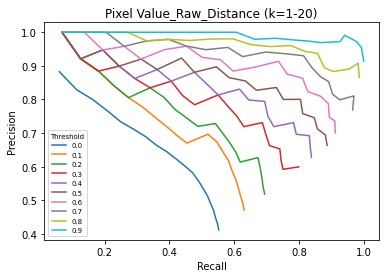

In [35]:
for recall, precision in zip(recalls_per_k, precisions_per_k):
    plt.plot(recall, precision)


plt.title("Pixel Value_Raw_Distance (k=1-20)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.rcParams['legend.title_fontsize'] = 'x-small'

plt.legend(labels, loc=0, fontsize ='x-small', title='Threshold')
plt.savefig('../Graphs/Pixel_Value_Raw_Distance.png', facecolor='white')
plt.show()
plt.close()


Label:  octopus
Precisions: 0.1
Recall:  0.07692307692307693


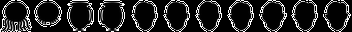


Label:  hat
Precisions: 0.9
Recall:  0.6


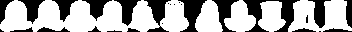


Label:  Glas
Precisions: 1.0
Recall:  0.7142857142857143


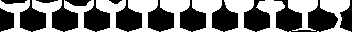


Label:  spoon
Precisions: 0.2
Recall:  0.125


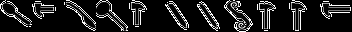


Label:  device9
Precisions: 1.0
Recall:  0.6666666666666666


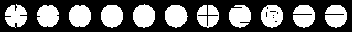


Label:  cattle
Precisions: 0.4
Recall:  0.3333333333333333


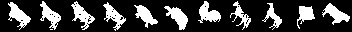


Label:  fly
Precisions: 0.0
Recall:  0.0


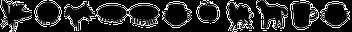


Label:  horseshoe
Precisions: 0.3
Recall:  0.2


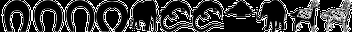


Label:  cattle
Precisions: 0.3
Recall:  0.25


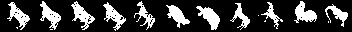


Label:  car
Precisions: 1.0
Recall:  0.5882352941176471


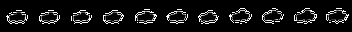


Label:  Comma
Precisions: 1.0
Recall:  0.6666666666666666


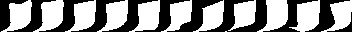


Label:  device8
Precisions: 0.9
Recall:  0.5625


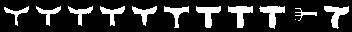


Label:  crown
Precisions: 0.7
Recall:  0.4117647058823529


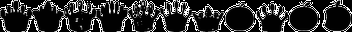


Label:  device5
Precisions: 1.0
Recall:  0.7142857142857143


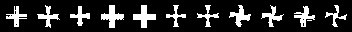


Label:  HCircle
Precisions: 1.0
Recall:  0.7142857142857143


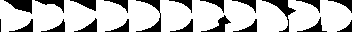


Label:  brick
Precisions: 0.6
Recall:  0.4


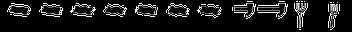


Label:  device6
Precisions: 1.0
Recall:  0.5555555555555556


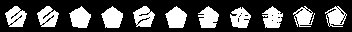


Label:  flatfish
Precisions: 1.0
Recall:  0.7142857142857143


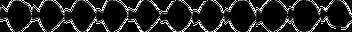


Label:  chopper
Precisions: 0.9
Recall:  0.8181818181818182


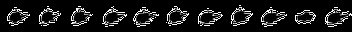


Label:  shoe
Precisions: 1.0
Recall:  0.5555555555555556


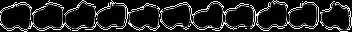


Label:  cup
Precisions: 0.9
Recall:  0.5625


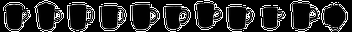


Label:  HCircle
Precisions: 1.0
Recall:  0.7142857142857143


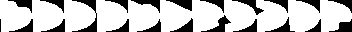


Label:  device5
Precisions: 1.0
Recall:  0.7142857142857143


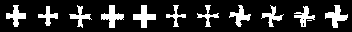


Label:  stef
Precisions: 1.0
Recall:  0.5555555555555556


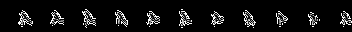


Label:  lmfish
Precisions: 0.1
Recall:  0.058823529411764705


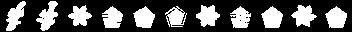


Label:  bell
Precisions: 0.0
Recall:  0.0


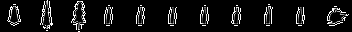


Label:  cattle
Precisions: 0.4
Recall:  0.3333333333333333


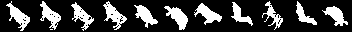


Label:  device3
Precisions: 0.6
Recall:  0.42857142857142855


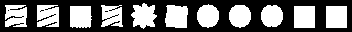


Label:  guitar
Precisions: 0.1
Recall:  0.06666666666666667


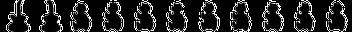


Label:  horse
Precisions: 0.1
Recall:  0.06666666666666667


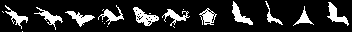


Label:  fountain
Precisions: 1.0
Recall:  0.5882352941176471


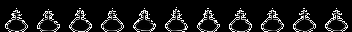


Label:  Misk
Precisions: 1.0
Recall:  0.6666666666666666


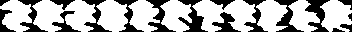


Label:  flatfish
Precisions: 1.0
Recall:  0.7142857142857143


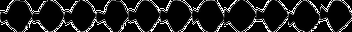


Label:  key
Precisions: 1.0
Recall:  0.7142857142857143


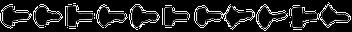


Label:  flatfish
Precisions: 1.0
Recall:  0.7142857142857143


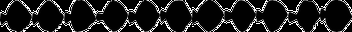


Label:  spring
Precisions: 0.0
Recall:  0.0


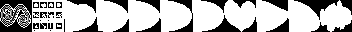


Label:  pencil
Precisions: 0.6
Recall:  0.375


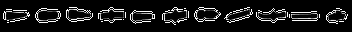


Label:  children
Precisions: 1.0
Recall:  0.5263157894736842


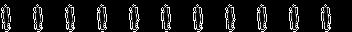


Label:  octopus
Precisions: 0.3
Recall:  0.23076923076923078


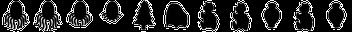


Label:  watch
Precisions: 0.4
Recall:  0.2857142857142857


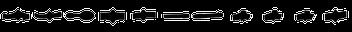


Label:  fly
Precisions: 0.0
Recall:  0.0


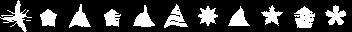


Label:  butterfly
Precisions: 0.1
Recall:  0.07142857142857142


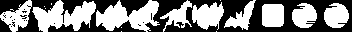


Label:  fish
Precisions: 1.0
Recall:  0.6666666666666666


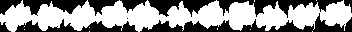


Label:  key
Precisions: 1.0
Recall:  0.7142857142857143


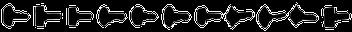


Label:  octopus
Precisions: 0.1
Recall:  0.07692307692307693


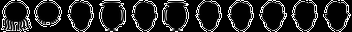


Label:  hat
Precisions: 0.9
Recall:  0.6


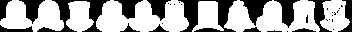


Label:  horse
Precisions: 0.4
Recall:  0.26666666666666666


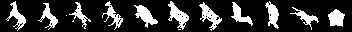


Label:  bottle
Precisions: 0.7
Recall:  0.5


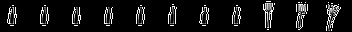


Label:  Glas
Precisions: 1.0
Recall:  0.7142857142857143


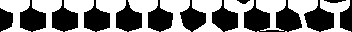


Label:  Glas
Precisions: 1.0
Recall:  0.7142857142857143


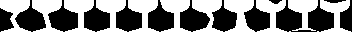


Label:  bell
Precisions: 1.0
Recall:  0.6666666666666666


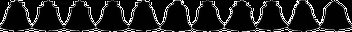


Label:  hat
Precisions: 0.9
Recall:  0.6


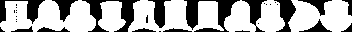


Label:  cellular_phone
Precisions: 0.9
Recall:  0.6923076923076923


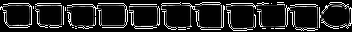


Label:  HCircle
Precisions: 1.0
Recall:  0.7142857142857143


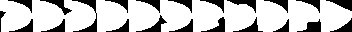


Label:  HCircle
Precisions: 1.0
Recall:  0.7142857142857143


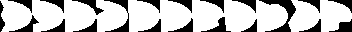


Label:  butterfly
Precisions: 0.3
Recall:  0.21428571428571427


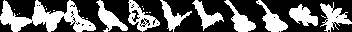


Label:  key
Precisions: 0.9
Recall:  0.6428571428571429


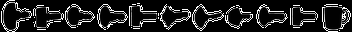


Label:  pocket
Precisions: 0.7
Recall:  0.4117647058823529


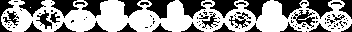


Label:  device0
Precisions: 0.6
Recall:  0.42857142857142855


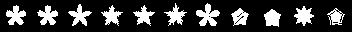


Label:  horseshoe
Precisions: 0.7
Recall:  0.4666666666666667


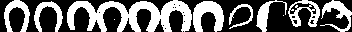


Label:  ray
Precisions: 0.4
Recall:  0.36363636363636365


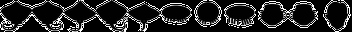


Label:  octopus
Precisions: 0.3
Recall:  0.23076923076923078


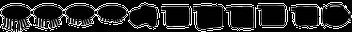


Label:  device9
Precisions: 1.0
Recall:  0.6666666666666666


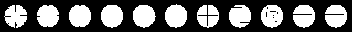


Label:  cellular_phone
Precisions: 1.0
Recall:  0.7692307692307693


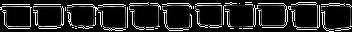


Label:  ray
Precisions: 0.3
Recall:  0.2727272727272727


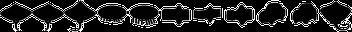


Label:  fork
Precisions: 0.3
Recall:  0.23076923076923078


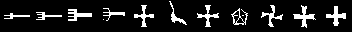


Label:  bird
Precisions: 0.0
Recall:  0.0


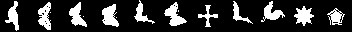


Label:  device9
Precisions: 0.9
Recall:  0.6


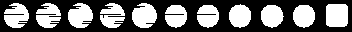


Label:  truck
Precisions: 1.0
Recall:  0.6666666666666666


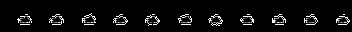


Label:  bell
Precisions: 1.0
Recall:  0.6666666666666666


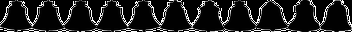


Label:  elephant
Precisions: 0.3
Recall:  0.17647058823529413


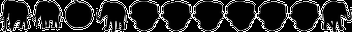


Label:  chopper
Precisions: 0.9
Recall:  0.8181818181818182


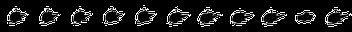


Label:  bird
Precisions: 0.4
Recall:  0.23529411764705882


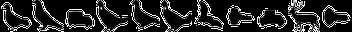


Label:  butterfly
Precisions: 0.3
Recall:  0.21428571428571427


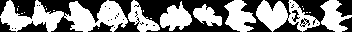


Label:  bell
Precisions: 1.0
Recall:  0.6666666666666666


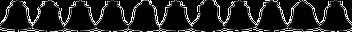


Label:  face
Precisions: 0.9
Recall:  0.5625


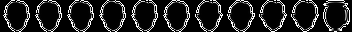


Label:  hammer
Precisions: 0.4
Recall:  0.25


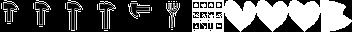


Label:  guitar
Precisions: 0.0
Recall:  0.0


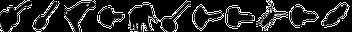


Label:  truck
Precisions: 0.8
Recall:  0.5333333333333333


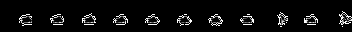


Label:  Glas
Precisions: 0.0
Recall:  0.0


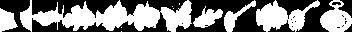


Label:  guitar
Precisions: 0.5
Recall:  0.3333333333333333


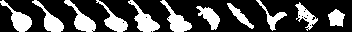


Label:  bottle
Precisions: 0.7
Recall:  0.5


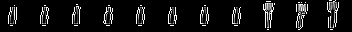


Label:  chopper
Precisions: 1.0
Recall:  0.9090909090909091


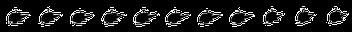


Label:  fork
Precisions: 0.4
Recall:  0.3076923076923077


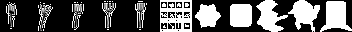


Label:  device3
Precisions: 0.7
Recall:  0.5


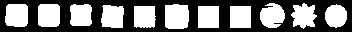


Label:  device5
Precisions: 1.0
Recall:  0.7142857142857143


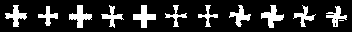


Label:  device4
Precisions: 1.0
Recall:  0.625


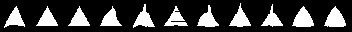


Label:  elephant
Precisions: 0.3
Recall:  0.17647058823529413


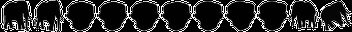


Label:  key
Precisions: 1.0
Recall:  0.7142857142857143


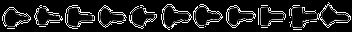


Label:  lizzard
Precisions: 0.1
Recall:  0.0625


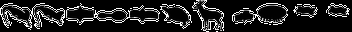


Label:  device0
Precisions: 0.6
Recall:  0.42857142857142855


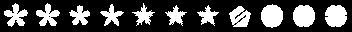


Label:  horseshoe
Precisions: 0.6
Recall:  0.4


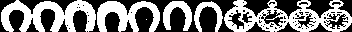


Label:  HCircle
Precisions: 1.0
Recall:  0.7142857142857143


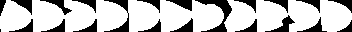


Label:  fountain
Precisions: 1.0
Recall:  0.5882352941176471


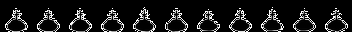


Label:  device4
Precisions: 1.0
Recall:  0.625


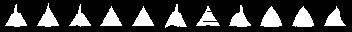


Label:  chopper
Precisions: 1.0
Recall:  0.9090909090909091


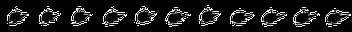


Label:  horse
Precisions: 0.3
Recall:  0.2


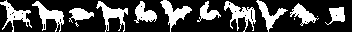


Label:  device8
Precisions: 1.0
Recall:  0.625


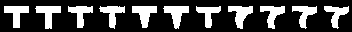


Label:  cellular_phone
Precisions: 1.0
Recall:  0.7692307692307693


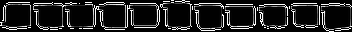


Label:  cellular_phone
Precisions: 1.0
Recall:  0.7692307692307693


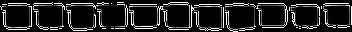

([0.1,
  0.9,
  1.0,
  0.2,
  1.0,
  0.4,
  0.0,
  0.3,
  0.3,
  1.0,
  1.0,
  0.9,
  0.7,
  1.0,
  1.0,
  0.6,
  1.0,
  1.0,
  0.9,
  1.0,
  0.9,
  1.0,
  1.0,
  1.0,
  0.1,
  0.0,
  0.4,
  0.6,
  0.1,
  0.1,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.0,
  0.6,
  1.0,
  0.3,
  0.4,
  0.0,
  0.1,
  1.0,
  1.0,
  0.1,
  0.9,
  0.4,
  0.7,
  1.0,
  1.0,
  1.0,
  0.9,
  0.9,
  1.0,
  1.0,
  0.3,
  0.9,
  0.7,
  0.6,
  0.7,
  0.4,
  0.3,
  1.0,
  1.0,
  0.3,
  0.3,
  0.0,
  0.9,
  1.0,
  1.0,
  0.3,
  0.9,
  0.4,
  0.3,
  1.0,
  0.9,
  0.4,
  0.0,
  0.8,
  0.0,
  0.5,
  0.7,
  1.0,
  0.4,
  0.7,
  1.0,
  1.0,
  0.3,
  1.0,
  0.1,
  0.6,
  0.6,
  1.0,
  1.0,
  1.0,
  1.0,
  0.3,
  1.0,
  1.0,
  1.0,
  1.0,
  0.7,
  0.3,
  0.9,
  0.7,
  1.0,
  0.9,
  0.1,
  1.0,
  0.9,
  0.4,
  0.0,
  0.8,
  1.0,
  0.3,
  0.0,
  1.0,
  0.7,
  0.6,
  1.0,
  0.4,
  0.8,
  0.6,
  0.7,
  0.7,
  0.9,
  0.0,
  0.6,
  1.0,
  1.0,
  0.9,
  0.5,
  0.3,
  0.4,
  1.0,
  1.0,
  0.3,
  0.6,
  1.0,
  0.6,
  0.5,
  0.3,
  0.2,

In [41]:
sort_by_distance(X_train, X_test, train_names, test_names, image_display_num=100, k=10)

In [20]:
raw_distance_mAP = np.average(averages)
for threshold, avg in zip(labels, averages):
    print("Threshold: {0} mAP: {1:.2f}".format(threshold, avg))
print("\nOverall mAP for k={0} to {1}: {2:.4f}".format(K_START_RANGE, K_END_RANGE, raw_distance_mAP))

Threshold: 0.0 mAP: 0.62
Threshold: 0.1 mAP: 0.69
Threshold: 0.2 mAP: 0.73
Threshold: 0.3 mAP: 0.77
Threshold: 0.4 mAP: 0.81
Threshold: 0.5 mAP: 0.84
Threshold: 0.6 mAP: 0.88
Threshold: 0.7 mAP: 0.92
Threshold: 0.8 mAP: 0.95
Threshold: 0.9 mAP: 0.98

Overall mAP for k=1 to 20: 0.8193


In [17]:
# Rename and Store Variables to be Presented in Different Notebook
raw_distance_averages = averages
%store raw_distance_averages
%store raw_distance_mAP
%store labels

Stored 'raw_distance_averages' (list)
Stored 'raw_distance_mAP' (float64)
Stored 'labels' (list)


In [18]:
dill.dump_session("Pixel_Value_Raw_Distance.db")